Dans le cadre d'une validation croisée ou un k-folds, nous allons diviser notre jeu de donnée en k sous échantillon. Nous allons par la suite former un modèle d'apprentissage sur les k-1 folds et nous allons évaluer sur celui qui n'a pas été vu. Nous répetons par la suite cette opération k fois en changeant à chaque fois l'échantillon d'évaluation. Cette méthode fournit une estimation fiable de la valeur de l'empirical loss qui permet d'évaluer le modèle 

Un split train / test est la technique usuelle qui permet de caractériser de manière quantitative la performance d'un modèle donné sur un data set. Nous entrainons un modèle sur le train et nous évaluons par la suite sa performance sur le test. Cette méthode requiert un temps de calcul moindre que la validation croisée mais est souvent un moins bon estimateur du risque empirique que le k-folds

Les modèles ensemblistes sont basé sur l'usage combinée d'un ensemble de prédicteur. Suivant la nature de la méthode ensembliste utilisée, elle permet de lever la variance (bagging) ou de débiaiser (boosting) le prédicteur. Parmis les algorithmes classisques basées sur une méthode ensembliste nous pouvons citer le random forest. 

# Import des fonctions 

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Import des data sets

In [146]:
train = pd.read_csv("train.csv")

In [192]:
survival_proportions = train['Survived'].value_counts(normalize=True)
print(survival_proportions)


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [147]:
teste = pd.read_csv("test.csv")

In [148]:
survie = pd.read_csv("gender_submission.csv")

In [149]:
test = pd.merge(teste, survie, on='PassengerId', how='outer')


In [193]:
survival_proportions_1 = test['Survived'].value_counts(normalize=True)
print(survival_proportions_1)

Survived
0    0.636364
1    0.363636
Name: proportion, dtype: float64


In [150]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


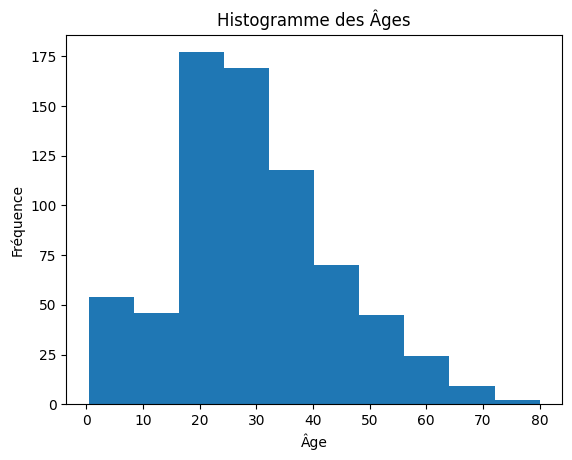

In [151]:
plt.hist(train['Age'], bins=10)  # Vous pouvez ajuster le nombre de 'bins' selon vos besoins
plt.title('Histogramme des Âges')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

In [152]:
contingency_table = pd.crosstab(train['Pclass'], train['Survived'])

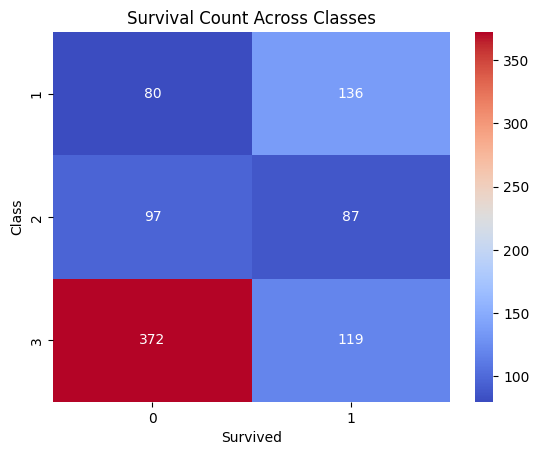

In [153]:
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='g')
plt.title('Survival Count Across Classes')
plt.ylabel('Class')
plt.xlabel('Survived')
plt.show()


In [154]:
na_proportions = train.isna().mean()
columns_with_na = na_proportions[na_proportions > 0]

In [155]:
print(columns_with_na)

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64


Here the idea is to drop the columns whose proportion of na is bigger than 0.5. 

In [156]:
train = train.drop('Cabin', axis= 1)

In [157]:
contingency_table_1 = pd.crosstab(train['Age'], train['Survived'])

We can assume that there is a relashionship betwwen the age and the class of the passangers. On the basis of that a first approximation would be to fit the na in the age with the median of the elements belonging to the same target class 1 , 2 and 3

In [158]:
median_ages = train.groupby('Pclass')['Age'].median()
print(median_ages)

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


In [159]:
for class_level in median_ages.index:
    train.loc[(train['Age'].isna()) & (train['Pclass'] == class_level), 'Age'] = median_ages[class_level]

Une autre approche aurait pu consister en travaillant avec une méthode de regression linéaire et prédire l'age en fonction des paramètres du modèle 

Pour embarked qui est une variable catégorielle, nous allons supposer qu'il y a une relation entre cette feature et les colonnes survies et la classe du passager nous allons par la suite remplir les NA et en effectuant un vote majoritaire le vote majoritaire se base sur la proportion afin de tenir compte des différences possibles en terme de déséquilibre des classes

In [160]:
embarked_proportions = train.groupby(['Survived', 'Pclass'])['Embarked'].value_counts(normalize=True)
print(embarked_proportions)

Survived  Pclass  Embarked
0         1       S           0.662500
                  C           0.325000
                  Q           0.012500
          2       S           0.907216
                  C           0.082474
                  Q           0.010309
          3       S           0.768817
                  Q           0.120968
                  C           0.110215
1         1       S           0.552239
                  C           0.440299
                  Q           0.007463
          2       S           0.873563
                  C           0.103448
                  Q           0.022989
          3       S           0.563025
                  Q           0.226891
                  C           0.210084
Name: proportion, dtype: float64


In [161]:
majoritary_embarked = embarked_proportions.groupby(level=[0, 1]).idxmax()
print(majoritary_embarked)

Survived  Pclass
0         1         (0, 1, S)
          2         (0, 2, S)
          3         (0, 3, S)
1         1         (1, 1, S)
          2         (1, 2, S)
          3         (1, 3, S)
Name: proportion, dtype: object


In [162]:
for index, embarked_category in majoritary_embarked.items():
    mask = (train['Survived'] == index[0]) & (train['Pclass'] == index[1]) & (train['Embarked'].isna())
    train.loc[mask, 'Embarked'] = embarked_category[2]


Il n'y a pas de relation d'ordre entre les variables hommes et femmes il faudrait donc faire un one hot encoding 

In [163]:
train_encoded = pd.get_dummies(train, columns=['Sex'])

We are also going to do a one hot encoding for the columns Embarked

In [164]:
train_final = pd.get_dummies(train_encoded, columns=['Embarked'])

In [165]:
train_final

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,False,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,True,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,True,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,False,True,False,False,True
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,True,False,False,False,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,True,False,False,False,True
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,False,True,True,False,False


It also seems that some features does not seem to encapsulate a relationship between the target which is the survival and themselves. This targets are the PassengerId, Name, SibSp, Parch and Ticket. All of this columns should be dropped

In [166]:
columns_to_be_dropped = ["PassengerId" ,"Name" , "SibSp", "Parch",	"Ticket"]

In [167]:
train_final = train_final.drop(columns_to_be_dropped , axis = 1)

In [168]:
train_final.astype('int')

,Survived,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22,7,0,1,0,0,1
1,1,1,38,71,1,0,1,0,0
2,1,3,26,7,1,0,0,0,1
3,1,1,35,53,1,0,0,0,1
4,0,3,35,8,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,27,13,0,1,0,0,1
887,1,1,19,30,1,0,0,0,1
888,0,3,24,23,1,0,0,0,1
889,1,1,26,30,0,1,1,0,0


# Réalisation du pré-traitement sur le test

In [169]:
median_ages = test.groupby('Pclass')['Age'].median()
print(median_ages)

Pclass
1    42.0
2    26.5
3    24.0
Name: Age, dtype: float64


In [170]:
median_ages_1 = test.groupby('Pclass')['Age'].median()
print(median_ages_1)

Pclass
1    42.0
2    26.5
3    24.0
Name: Age, dtype: float64


In [171]:
for class_level in median_ages_1.index:
    test.loc[(test['Age'].isna()) & (test['Pclass'] == class_level), 'Age'] = median_ages_1[class_level]

In [172]:
mean_fares = test.groupby('Pclass')['Fare'].mean()


In [173]:
for pclass in mean_fares.index:
    test.loc[(test['Pclass'] == pclass) & (test['Fare'].isna()), 'Fare'] = mean_fares[pclass]

In [174]:
columns_to_be_dropped = ["PassengerId" ,"Name" , "SibSp", "Parch",	"Ticket" , "Cabin"]

In [175]:
test = test.drop(columns_to_be_dropped , axis = 1)

In [176]:
test_final = pd.get_dummies(test, columns=['Sex'])

In [177]:
test_final = pd.get_dummies(test_final, columns=['Embarked'])

In [178]:
test_final

,Pclass,Age,Fare,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,7.8292,0,False,True,False,True,False
1,3,47.0,7.0000,1,True,False,False,False,True
2,2,62.0,9.6875,0,False,True,False,True,False
3,3,27.0,8.6625,0,False,True,False,False,True
4,3,22.0,12.2875,1,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...
413,3,24.0,8.0500,0,False,True,False,False,True
414,1,39.0,108.9000,1,True,False,True,False,False
415,3,38.5,7.2500,0,False,True,False,False,True
416,3,24.0,8.0500,0,False,True,False,False,True


# Choix du modele 

J'ai choisi un random forest pour avoir un modèle flexible dont les paramètres sont faciles à identifier à savoir la profondeur des arabres et surtout un modèle qui est capable de gérer diffent type d'input qui varient sur différent intervals

In [179]:
y_train = train_final['Survived']


In [180]:
train_final = train_final.drop('Survived' , axis = 1) 

In [181]:
y_test = test_final['Survived']

In [182]:
test_final = test_final.drop('Survived' , axis = 1) 

In [198]:
max_depths = range(1, 21)  # Depths from 1 to 20
tpr_values = []
tnr_values = []

for depth in max_depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=42)
    clf.fit(train_final.astype('int'), y_train)
    y_pred = clf.predict(test_final.astype('int'))
    cm = confusion_matrix(y_test, y_pred)

    TPR = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positives / (True Positives + False Negatives)
    TNR = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negatives / (True Negatives + False Positives)

    tpr_values.append(TPR)
    tnr_values.append(TNR)
    print(f"Depth: {depth}, True Positive Rate: {TPR}, True Negative Rate: {TNR}")


Depth: 1, True Positive Rate: 0.75, True Negative Rate: 1.0
Depth: 2, True Positive Rate: 1.0, True Negative Rate: 1.0
Depth: 3, True Positive Rate: 0.993421052631579, True Negative Rate: 0.9962406015037594
Depth: 4, True Positive Rate: 0.868421052631579, True Negative Rate: 0.9924812030075187
Depth: 5, True Positive Rate: 0.8355263157894737, True Negative Rate: 0.9699248120300752
Depth: 6, True Positive Rate: 0.8092105263157895, True Negative Rate: 0.9548872180451128
Depth: 7, True Positive Rate: 0.7960526315789473, True Negative Rate: 0.943609022556391
Depth: 8, True Positive Rate: 0.8092105263157895, True Negative Rate: 0.9172932330827067
Depth: 9, True Positive Rate: 0.7960526315789473, True Negative Rate: 0.8947368421052632
Depth: 10, True Positive Rate: 0.7894736842105263, True Negative Rate: 0.8872180451127819
Depth: 11, True Positive Rate: 0.8026315789473685, True Negative Rate: 0.8947368421052632
Depth: 12, True Positive Rate: 0.7960526315789473, True Negative Rate: 0.88345864

J'ai choisi de travailler avec les taux de vrais positifes et les taux de vrais négatives car les classes me paraissent pas équilibrés. J'ai un modèle dont les métriques d'évaluation augmentent au fur et à mesure et ensuite chute drastiquement ce qui traduit que le modèle overfit à partir d'une certaine profondeur

We can stop at a depth of 2 for the choice of the parameters 

In [200]:
max_depths = range(1, 21)  # Depths from 1 to 20
tpr_values = []
tnr_values = []

# Define the number of folds for cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for depth in max_depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=42)
    
    # Generate cross-validated estimates for each input data point
    y_pred = cross_val_predict(clf, train_final.astype('int'), y_train, cv=cv)

    cm = confusion_matrix(y_train , y_pred)
    TPR = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positives / (True Positives + False Negatives)
    TNR = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negatives / (True Negatives + False Positives)

    tpr_values.append(TPR)
    tnr_values.append(TNR)
    print(f"Depth: {depth}, True Positive Rate: {TPR}, True Negative Rate: {TNR}")


Depth: 1, True Positive Rate: 0.5818713450292398, True Negative Rate: 0.9034608378870674
Depth: 2, True Positive Rate: 0.6491228070175439, True Negative Rate: 0.8652094717668488
Depth: 3, True Positive Rate: 0.6637426900584795, True Negative Rate: 0.8597449908925319
Depth: 4, True Positive Rate: 0.6432748538011696, True Negative Rate: 0.9253187613843351
Depth: 5, True Positive Rate: 0.6461988304093568, True Negative Rate: 0.9344262295081968
Depth: 6, True Positive Rate: 0.6842105263157895, True Negative Rate: 0.936247723132969
Depth: 7, True Positive Rate: 0.6988304093567251, True Negative Rate: 0.9289617486338798
Depth: 8, True Positive Rate: 0.7368421052631579, True Negative Rate: 0.9216757741347905
Depth: 9, True Positive Rate: 0.7573099415204678, True Negative Rate: 0.907103825136612
Depth: 10, True Positive Rate: 0.7514619883040936, True Negative Rate: 0.907103825136612
Depth: 11, True Positive Rate: 0.7573099415204678, True Negative Rate: 0.8888888888888888
Depth: 12, True Positi